In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import time
from keras.preprocessing.text import tokenizer_from_json
import json

In [4]:
pip install openpyxl

Defaulting to user installation because normal site-packages is not writeable
     -------------------------------------- 250.0/250.0 kB 1.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
## Read the train data
train_data = pd.read_csv("./data/data.csv")
train_data

,text,generated
0,Cars. Cars have been around since they became ...,0
1,Transportation is a large necessity in most co...,0
2,"""America's love affair with it's vehicles seem...",0
3,How often do you ride in a car? Do you drive a...,0
4,Cars are a wonderful thing. They are perhaps o...,0
...,...,...
1460,Plastic tableware's pervasive use and disposab...,1
1461,The age of 18 as the legal voting age is a pro...,1
1462,Addressing homelessness requires multifaceted ...,1
1463,Artificial Intelligence (AI) stands as a trans...,1


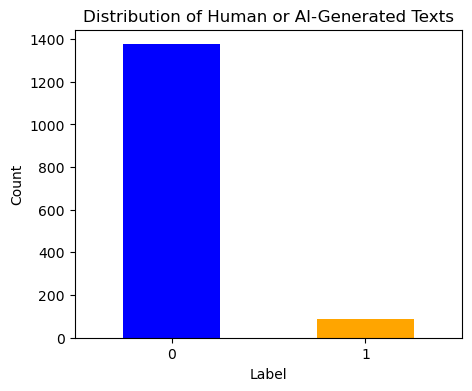

In [3]:
## check data skuness
import matplotlib.pyplot as plt
label_counts = train_data['generated'].value_counts()
plt.figure(figsize=(5, 4))
label_counts.plot(kind='bar', color=['blue', 'orange'])
plt.title('Distribution of Human or AI-Generated Texts')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [4]:
## downsample the data
data_human = train_data[train_data['generated'] == 0]
data_machine = train_data[train_data['generated'] == 1]
downsampled = data_human.sample(data_machine.shape[0])
train_data = pd.concat([data_machine, downsampled])
train_data

,text,generated
1375,"Green energy, derived from renewable and susta...",1
1376,The evolution of Artificial Intelligence (AI) ...,1
1377,Global warming has escalated into an imminent ...,1
1378,"Bioinformatics, a dynamic interdisciplinary fi...",1
1379,In a world teeming with an abundance of choice...,1
...,...,...
1070,The black smoke that leaks out of your car's t...,0
162,"Dear Mr. Florida State Senator, My name is PRO...",0
930,The Electoral College is not perfect and it ma...,0
461,There are a lot advantages and disadvantages o...,0


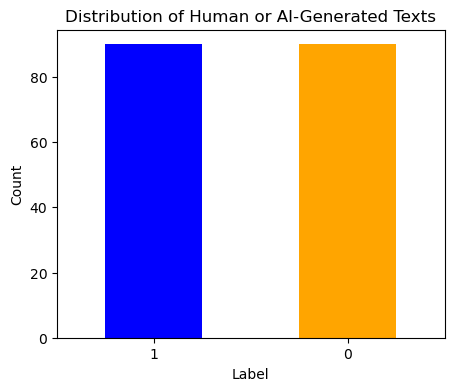

In [5]:
## check data skuness
import matplotlib.pyplot as plt
label_counts = train_data['generated'].value_counts()
plt.figure(figsize=(5, 4))
label_counts.plot(kind='bar', color=['blue', 'orange'])
plt.title('Distribution of Human or AI-Generated Texts')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [6]:
from collections import Counter
def counter_word(text):
    count = Counter()
    for i in text.values:
        for word in i.split():
            count[word] += 1
    return count

In [7]:
text = train_data.text
counter = counter_word(text)

In [8]:
len(counter)

10535

In [9]:
num_words=len(counter)
max_length = 200

In [10]:
## split the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_data['text'], train_data['generated'], stratify=train_data['generated'])

In [11]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(X_train)

In [12]:
word_index = tokenizer.word_index

In [13]:
train_sequences = tokenizer.texts_to_sequences(X_train)

In [14]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding="post", truncating="post")

In [15]:
train_padded[0]

array([   1, 3401,    3, 1664,  575, 2515,  185,    7,   24,  615,  471,
        191,  356,  718,   42,  616,  846, 1665,    2,    1,  576,    3,
       2007,  314,  315,    1,  244,    3, 2516, 1389,   17,  575,    7,
         24,  615,  471,  768, 1215,    4, 1216,  575,  847,    7,   24,
        615,  191,    2, 1058,   30, 2517,  846, 1665,    6,  300,  471,
        316,   11,  372,  542,   17,  575,    4, 2518,    2, 2008,   24,
        615,  191, 1059,    1,  192,    3,  846,  373,    6,  543, 2519,
          2, 1217,  396,  497,  134,    8,  414,  472,   97, 2009,  575,
          4,  131, 1666,  314,    4,  617,  471,  191,   32,   24,  245,
         11,   97, 1058,  575,    4,  473,    6,  374,   25,   24,  245,
         42,    1,  769,    3,  471,  437, 1390,   17, 2010,  191,    2,
       2520, 1391,   28, 1218,   36,  941,   88,   41,   10,  170,  135,
          2,  160,  195,  474,   25, 2516, 1389,   17,  575, 1667,  846,
        542,    7,    5, 1219,  191,   16,   12,  2

In [16]:
test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding="post", truncating="post")

In [17]:
## Check if mapping translates back to text
reverse_word_index = dict([(value,key) for (key,value) in word_index.items()])
def decode(text):
    return " ".join([reverse_word_index.get(i, "?") for i in text])

In [18]:
decode(train_sequences[0])

"the proposition of holding parents financially responsible for their children's bullying behavior raises questions about accountability parental involvement and the effectiveness of punitive measures firstly the idea of imposing fines on parents for their children's bullying actions aims to hold parents accountable for their children's behavior and encourage more active parental involvement in addressing bullying issues it places responsibility on parents to monitor and guide their children's behavior emphasizing the role of parental influence in shaping attitudes and conduct secondly proponents argue that financial consequences might motivate parents to take proactive measures to prevent bullying behavior by their children it might encourage parents to engage in discussions with their children about the impacts of bullying provide guidance on respectful behavior and seek intervention or counseling if needed however there are potential challenges and ethical concerns associated with i

In [19]:
## Make the LSTM model
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.initializers import Constant
from keras.optimizers import Adam

model = Sequential()
model.add(Embedding(num_words, 32, input_length=max_length))
model.add(LSTM(64, dropout=0.1))
model.add(Dense(1, activation="sigmoid"))

optimizer = Adam(learning_rate=3e-4)
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 32)           337120    
                                                                 
 lstm (LSTM)                 (None, 64)                24832     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 362,017
Trainable params: 362,017
Non-trainable params: 0
_________________________________________________________________


In [21]:
model.fit(train_padded, y_train, epochs=20, validation_data=(test_padded, y_test))

Epoch 1/20
5/5 [==============================] - 5s 186ms/step - loss: 0.6934 - accuracy: 0.5333 - val_loss: 0.6932 - val_accuracy: 0.4222
Epoch 2/20
5/5 [==============================] - 0s 30ms/step - loss: 0.6921 - accuracy: 0.6000 - val_loss: 0.6925 - val_accuracy: 0.4222
Epoch 3/20
5/5 [==============================] - 0s 34ms/step - loss: 0.6910 - accuracy: 0.6370 - val_loss: 0.6914 - val_accuracy: 0.5556
Epoch 4/20
5/5 [==============================] - 0s 31ms/step - loss: 0.6894 - accuracy: 0.7481 - val_loss: 0.6899 - val_accuracy: 0.6889
Epoch 5/20
5/5 [==============================] - 0s 35ms/step - loss: 0.6870 - accuracy: 0.8667 - val_loss: 0.6879 - val_accuracy: 0.7556
Epoch 6/20
5/5 [==============================] - 0s 30ms/step - loss: 0.6835 - accuracy: 0.9111 - val_loss: 0.6845 - val_accuracy: 0.7556
Epoch 7/20
5/5 [==============================] - 0s 32ms/step - loss: 0.6780 - accuracy: 0.9630 - val_loss: 0.6785 - val_accuracy: 0.8222
Epoch 8/20
5/5 [==========

In [22]:
model.predict(test_padded)

2/2 [==============================] - 0s 9ms/step


array([[0.9792113 ],
       [0.97951573],
       [0.04819248],
       [0.04796474],
       [0.0474784 ],
       [0.05150995],
       [0.97844076],
       [0.9789478 ],
       [0.05385152],
       [0.04702891],
       [0.9791378 ],
       [0.9792306 ],
       [0.04797965],
       [0.04813826],
       [0.04771962],
       [0.9794891 ],
       [0.05299015],
       [0.9789449 ],
       [0.04846856],
       [0.05081227],
       [0.97892225],
       [0.0493637 ],
       [0.04666165],
       [0.04774886],
       [0.9792155 ],
       [0.97901756],
       [0.04925724],
       [0.04758464],
       [0.04799878],
       [0.04916813],
       [0.9787057 ],
       [0.04910406],
       [0.97892034],
       [0.9785715 ],
       [0.9793464 ],
       [0.04961303],
       [0.04995295],
       [0.9790551 ],
       [0.04820962],
       [0.04883214],
       [0.97963184],
       [0.04757958],
       [0.9786502 ],
       [0.04851962],
       [0.9790426 ]], dtype=float32)

In [23]:
y_test

1392    1
1400    1
457     0
1104    0
776     0
1389    1
1310    0
1376    1
1396    1
1364    0
1454    1
1407    1
936     0
452     0
908     0
1424    1
1461    1
1433    1
1238    0
1405    1
1448    1
1061    0
1245    0
527     0
1442    1
1415    1
984     0
1012    0
40      0
728     0
1431    1
934     0
1463    1
1428    1
1386    1
57      0
1345    0
1406    1
515     0
1356    0
1411    1
316     0
1445    1
162     0
1385    1
Name: generated, dtype: int64

In [24]:
model.evaluate(test_padded, y_test)

2/2 [==============================] - 0s 15ms/step - loss: 0.3803 - accuracy: 0.8889


[0.3802500069141388, 0.8888888955116272]

In [25]:
tokenizer_json = tokenizer.to_json()

In [26]:
with open('tokenizer_new.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

In [27]:
model.save('my_model.keras')